### Imports and Setup

In [46]:
import keras
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, BatchNormalization, concatenate, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, History
from keras.layers import SpatialDropout2D
from keras import backend as K
from keras.optimizers import Adam
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from warnings import filterwarnings

filterwarnings('ignore')
np.random.seed(101)

In [47]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

### Data

In [48]:
image_size = (224,224)

filelist_trainx_path = 'ISIC-2017/ISIC-2017_Training_Data'
filelist_trainx = sorted(glob.glob(filelist_trainx_path + '/*.jpg'), key=numericalSort)
filelist_length = len(filelist_trainx)

X_train = np.array([np.array(Image.open(fname).resize(image_size)) for fname in filelist_trainx
   ])

In [49]:
filelist_trainy_path = 'ISIC-2017/ISIC-2017_Training_Part1_GroundTruth'
filelist_trainy = sorted(glob.glob(filelist_trainy_path + '/*.png'), key=numericalSort)

Y_train = np.array([np.array(Image.open(fname).resize(image_size)) for fname in filelist_trainy])

In [50]:
Z_train = pd.read_csv('ISIC-2017/ISIC-2017_Training_Data/ISIC-2017_Training_Data_metadata.csv')
Z_train['sex'] = Z_train['sex'].map({'male': 0, 'female': 1})

In [56]:
# Z_train.iloc[407]
Z_train

,image_id,age_approximate,sex
0,ISIC_0000000,55,1.0
1,ISIC_0000001,30,1.0
2,ISIC_0000002,60,1.0
3,ISIC_0000003,30,0.0
4,ISIC_0000004,80,0.0
...,...,...,...
1995,ISIC_0015220,75,0.0
1996,ISIC_0015233,60,0.0
1997,ISIC_0015260,55,1.0
1998,ISIC_0015284,75,0.0


In [66]:
# TRYING TO SEE IF WE CAN USE THE 2019 METADATA by checking if 2019 has all the images in 2017
# Check if IDs in df_1 are in df_2
Z1_train = Z_train.copy()
Z2_train = pd.read_csv('ISIC-2019/ISIC_2019_Training_Metadata.csv')

Z1_train['ID_number'] = Z1_train['image_id'].str.extract(r'(\d+)')
# Convert the extracted numbers to integer type
Z1_train['ID_number'] = Z1_train['ID_number'].astype(int)

Z2_train['ID_number'] = Z2_train['image'].str.extract(r'(\d+)')
# Convert the extracted numbers to integer type
Z2_train['ID_number'] = Z2_train['ID_number'].astype(int)

id_2017 = Z1_train['ID_number'].to_numpy()
id_2019 = Z2_train['ID_number'].to_numpy()



# mask = ~np.isin(id_2017, id_2019)
# missing_elements = id_2017[mask]
mask = ~np.isin(id_2019, id_2017)
missing_elements = id_2019[mask]
print(missing_elements.size)
missing_elements


23331


array([   58,    60,   114, ..., 73249, 73251, 73254])

In [70]:
# Function to extract numerical part from ID
def extract_num_id(id):
    return re.findall(r'\d+', id)[0]

# Extract numerical IDs
Z1_train['NumID'] = Z1_train['image_id'].apply(extract_num_id)
Z2_train['NumID'] = Z2_train['image'].apply(extract_num_id)

# Find shared numerical IDs
shared_num_ids = set(Z1_train['NumID']).intersection(set(Z2_train['NumID']))

# Filter the DataFrames based on shared numerical IDs
df1_shared = Z1_train[Z1_train['NumID'].isin(shared_num_ids)]
df2_shared = Z2_train[Z2_train['NumID'].isin(shared_num_ids)]

# Merge the DataFrames to get combined information
shared_df = pd.merge(df1_shared, df2_shared, on='NumID', suffixes=('_df1', '_df2'))

# Drop the temporary NumID column
shared_df = shared_df.drop(columns=['NumID'])
shared_df = shared_df.drop(columns=['image', 'age_approx', 'sex_df2', 'image_id_in_Z2_train', 'ID_number_df2'])
shared_df

,image_id,age_approximate,sex_df1,ID_number_df1,anatom_site_general,lesion_id
0,ISIC_0000000,55,1.0,0,anterior torso,NaN
1,ISIC_0000001,30,1.0,1,anterior torso,NaN
2,ISIC_0000002,60,1.0,2,upper extremity,NaN
3,ISIC_0000003,30,0.0,3,upper extremity,NaN
4,ISIC_0000004,80,0.0,4,posterior torso,NaN
...,...,...,...,...,...,...
1995,ISIC_0015220,75,0.0,15220,head/neck,NaN
1996,ISIC_0015233,60,0.0,15233,head/neck,NaN
1997,ISIC_0015260,55,1.0,15260,upper extremity,NaN
1998,ISIC_0015284,75,0.0,15284,head/neck,NaN


In [6]:
print(X_train.shape)
print(Y_train.shape)

(2000, 224, 224, 3)
(2000, 224, 224)


In [7]:
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size = 0.25, random_state = 101)
print(x_train.shape)
print(y_train.shape)

(1500, 224, 224, 3)
(1500, 224, 224)


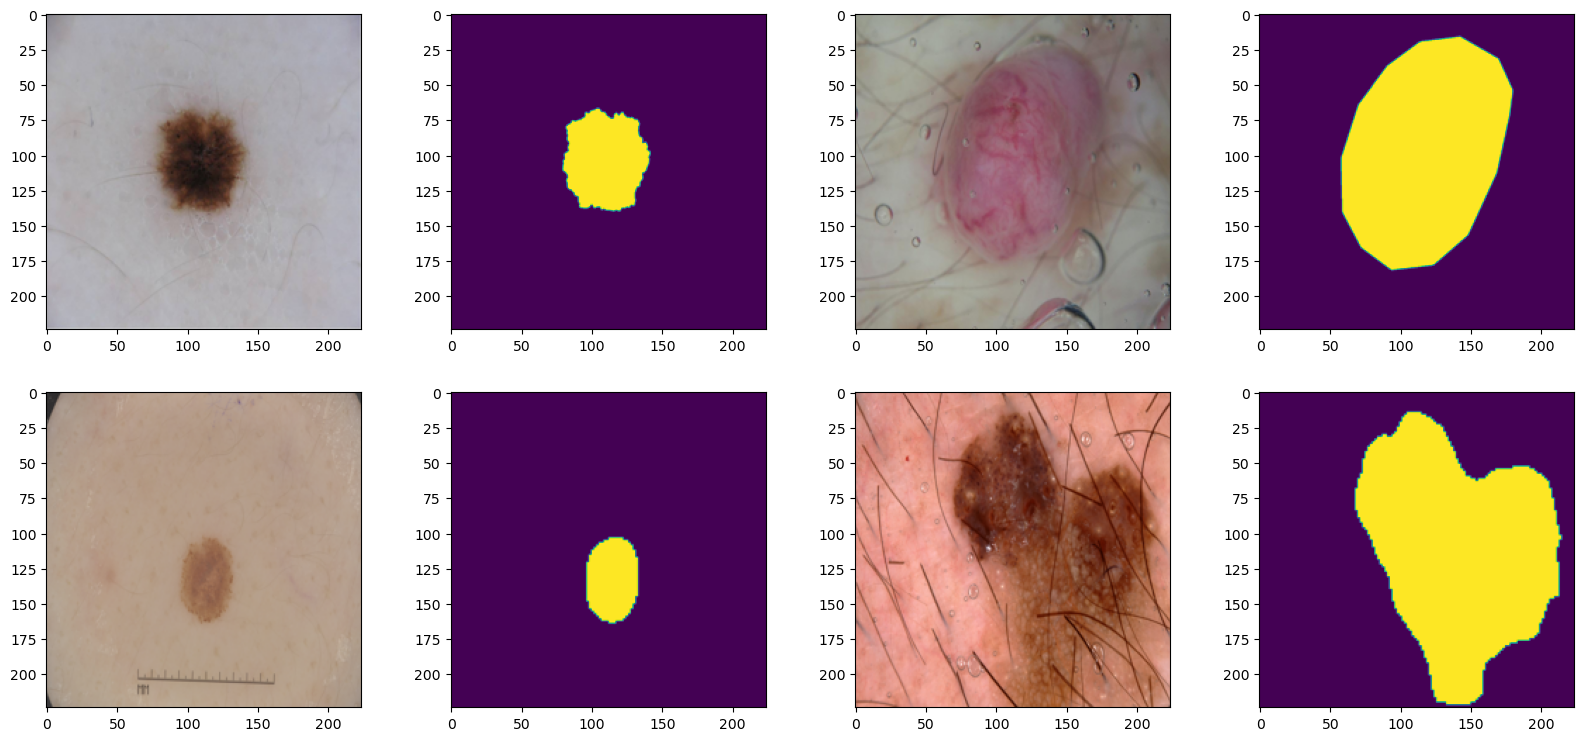

In [8]:
plt.figure(figsize=(20,9))

plt.subplot(2,4,1)
plt.imshow(X_train[1])
plt.subplot(2,4,2)
plt.imshow(Y_train[1])
plt.subplot(2,4,3)
plt.imshow(X_train[681])
plt.subplot(2,4,4)
plt.imshow(Y_train[681])
plt.subplot(2,4,5)
plt.imshow(X_train[1095])
plt.subplot(2,4,6)
plt.imshow(Y_train[1095])
plt.subplot(2,4,7)
plt.imshow(X_train[1978])
plt.subplot(2,4,8)
plt.imshow(Y_train[1978])
plt.show()

### Functions

In [9]:
def jaccard_distance(y_true, y_pred, smooth=100):
    y_true = K.cast(y_true, dtype=K.floatx())
    y_pred = K.cast(y_pred, dtype=K.floatx())
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac)

def iou(y_true, y_pred, smooth = 100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def dice_coe(y_true, y_pred, smooth = 100):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall
def accuracy(y_true, y_pred):
    '''Calculates the mean accuracy rate across all predictions for binary
    classification problems.
    '''
    return K.mean(K.equal(y_true, K.round(y_pred)))

In [10]:
#Image Augmentation
def random_rotation(x_image, y_image):
    rows_x,cols_x, chl_x = x_image.shape
    rows_y,cols_y = y_image.shape
    rand_num = np.random.randint(-40,40)
    M1 = cv2.getRotationMatrix2D((cols_x/2,rows_x/2),rand_num,1)
    M2 = cv2.getRotationMatrix2D((cols_y/2,rows_y/2),rand_num,1)
    x_image = cv2.warpAffine(x_image,M1,(cols_x,rows_x))
    y_image = cv2.warpAffine(y_image.astype('float32'),M2,(cols_y,rows_y))
    return x_image, y_image.astype('int')

def horizontal_flip(x_image, y_image):
    x_image = cv2.flip(x_image, 1)
    y_image = cv2.flip(y_image.astype('float32'), 1)
    return x_image, y_image.astype('int')
def img_augmentation(x_train, y_train):
    x_rotat = []
    y_rotat = []
    x_flip = []
    y_flip = []
    for idx in range(len(x_train)):
        x,y = random_rotation(x_train[idx], y_train[idx])
        x_rotat.append(x)
        y_rotat.append(y)
        x,y = horizontal_flip(x_train[idx], y_train[idx])
        x_flip.append(x)
        y_flip.append(y)
    return np.array(x_rotat), np.array(y_rotat), np.array(x_flip), np.array(y_flip)

In [11]:
x_rotated, y_rotated, x_flipped, y_flipped = img_augmentation(x_train, y_train)

In [12]:
x_train_full = np.concatenate([x_train, x_rotated, x_flipped])
y_train_full = np.concatenate([y_train, y_rotated, y_flipped])

In [13]:
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size = 0.20, random_state = 101)
print("Length of the Training Set   : {}".format(len(x_train)))
print("Length of the Test Set       : {}".format(len(x_test)))
print("Length of the Validation Set : {}".format(len(x_val)))

Length of the Training Set   : 3600
Length of the Test Set       : 500
Length of the Validation Set : 900


## Model

In [14]:
# Number of image channels (for example 3 in case of RGB, or 1 for grayscale images)
INPUT_CHANNELS = 3
# Number of output masks (1 in case you predict only one type of objects)
OUTPUT_MASK_CHANNELS = 1
# Pretrained weights

In [15]:
checkpoint = ModelCheckpoint(
    'best_model_weights.h5',  # Path where the model weights will be saved
    monitor='val_loss',      
    save_best_only=True,     
    mode='min',               # Mode 'min' to save the model with the minimum `val_loss`
    verbose=1             
)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

In [19]:
# Custom callback to save weights at specific epochs
class CustomModelCheckpoint(Callback):
    def __init__(self, save_epochs, filepath_template):
        super(CustomModelCheckpoint, self).__init__()
        self.save_epochs = save_epochs
        self.filepath_template = filepath_template

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) in self.save_epochs:
            filepath = self.filepath_template.format(epoch=epoch + 1)
            self.model.save_weights(filepath)
            print(f"\nEpoch {epoch + 1}: saving model to {filepath}")

# Define the specific epochs at which to save the weights
save_epochs = [50, 100, 150, 200]
# Define the file path template for saving weights
filepath_template = 'model_weights_epoch_{epoch:03d}.h5'

# Instantiate the custom callback
increment_checkpoints = CustomModelCheckpoint(save_epochs, filepath_template)

In [37]:
def double_conv_layer(x, size, dropout=0.40, batch_norm=True):
    if K.image_data_format() == 'channels_first':
        axis = 1
    else:
        axis = 3
    conv = Conv2D(size, (3, 3), padding='same')(x)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    conv = Conv2D(size, (3, 3), padding='same')(conv)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    if dropout > 0:
        conv = SpatialDropout2D(dropout)(conv)
    return conv


def UNET_224(epochs_num, savename, load_weights):
    dropout_val=0.50
    if K.image_data_format() == 'channels_first':
        inputs = Input((INPUT_CHANNELS, 224, 224))
        axis = 1
    else:
        inputs = Input((224, 224, INPUT_CHANNELS))
        axis = 3
    filters = 32

    conv_224 = double_conv_layer(inputs, filters)
    pool_112 = MaxPooling2D(pool_size=(2, 2))(conv_224)

    conv_112 = double_conv_layer(pool_112, 2*filters)
    pool_56 = MaxPooling2D(pool_size=(2, 2))(conv_112)

    conv_56 = double_conv_layer(pool_56, 4*filters)
    pool_28 = MaxPooling2D(pool_size=(2, 2))(conv_56)

    conv_28 = double_conv_layer(pool_28, 8*filters)
    pool_14 = MaxPooling2D(pool_size=(2, 2))(conv_28)

    conv_14 = double_conv_layer(pool_14, 16*filters)
    pool_7 = MaxPooling2D(pool_size=(2, 2))(conv_14)

    conv_7 = double_conv_layer(pool_7, 32*filters)

    up_14 = concatenate([UpSampling2D(size=(2, 2))(conv_7), conv_14], axis=axis)
    up_conv_14 = double_conv_layer(up_14, 16*filters)

    up_28 = concatenate([UpSampling2D(size=(2, 2))(up_conv_14), conv_28], axis=axis)
    up_conv_28 = double_conv_layer(up_28, 8*filters)

    up_56 = concatenate([UpSampling2D(size=(2, 2))(up_conv_28), conv_56], axis=axis)
    up_conv_56 = double_conv_layer(up_56, 4*filters)

    up_112 = concatenate([UpSampling2D(size=(2, 2))(up_conv_56), conv_112], axis=axis)
    up_conv_112 = double_conv_layer(up_112, 2*filters)

    up_224 = concatenate([UpSampling2D(size=(2, 2))(up_conv_112), conv_224], axis=axis)
    up_conv_224 = double_conv_layer(up_224, filters, dropout_val)

    conv_final = Conv2D(OUTPUT_MASK_CHANNELS, (1, 1))(up_conv_224)
    conv_final = Activation('sigmoid')(conv_final)
    pred = Reshape((224,224))(conv_final)

    model = Model(inputs, pred, name="UNET_224")

    if load_weights == True:
        model.load_weights('best_model_weights.h5')
        
    model.compile(optimizer= Adam(lr = 0.003), loss= [jaccard_distance]
                  , metrics=[iou, dice_coe, precision, recall, accuracy])
    model.summary()
    # hist = model.fit(x_train, y_train, epochs=1, batch_size= 1,validation_data=(x_val, y_val), verbose=1)
    hist = model.fit(x_train, y_train, 
                     epochs=epochs_num, 
                     batch_size= 32,
                     validation_data=(x_val, y_val), 
                     verbose=1,
                     callbacks=[checkpoint, increment_checkpoints, early_stopping])
    model.save(savename)
    return model,hist

In [34]:
model, hist = UNET_224(200, 'unet_20_epoch.h5', True)


Model: "UNET_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_46 (Conv2D)              (None, 224, 224, 32) 896         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_44 (BatchNo (None, 224, 224, 32) 128         conv2d_46[0][0]                  
__________________________________________________________________________________________________
activation_46 (Activation)      (None, 224, 224, 32) 0           batch_normalization_44[0][0]     
___________________________________________________________________________________________

2024-06-20 15:26:02.388669: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1445068800 exceeds 10% of free system memory.


Epoch 1/200
113/113 [==============================] - 32s 266ms/step - loss: 0.5828 - iou: 0.4172 - dice_coe: 0.7249 - precision: 8.1141 - recall: 0.9960 - accuracy: 0.7262 - val_loss: 0.5778 - val_iou: 0.4222 - val_dice_coe: 1.3147 - val_precision: 0.6565 - val_recall: 0.9981 - val_accuracy: 0.6251

Epoch 00001: val_loss did not improve from 0.51583
Epoch 2/200
113/113 [==============================] - 29s 261ms/step - loss: 0.5361 - iou: 0.4639 - dice_coe: 0.1496 - precision: 137658817146.5345 - recall: 0.9499 - accuracy: 0.7912 - val_loss: 0.5158 - val_iou: 0.4842 - val_dice_coe: 0.0372 - val_precision: 2284461752320.0000 - val_recall: 0.7563 - val_accuracy: 0.8054

Epoch 00002: val_loss improved from 0.51583 to 0.51580, saving model to best_model_weights.h5
Epoch 3/200
113/113 [==============================] - 29s 261ms/step - loss: 0.5262 - iou: 0.4738 - dice_coe: 0.0744 - precision: 2041209370085.0527 - recall: 0.8567 - accuracy: 0.8001 - val_loss: 0.5157 - val_iou: 0.4843 - v

### Predictions

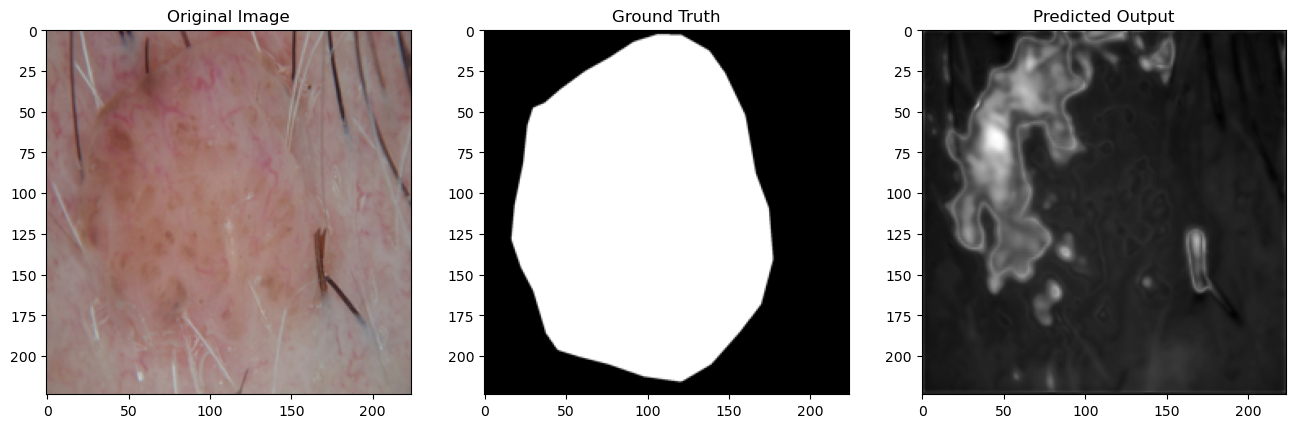

In [33]:
# Prediction for a single image
img_num = 104
img_pred = model.predict(x_test[img_num].reshape(1,224,224,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(224, 224), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

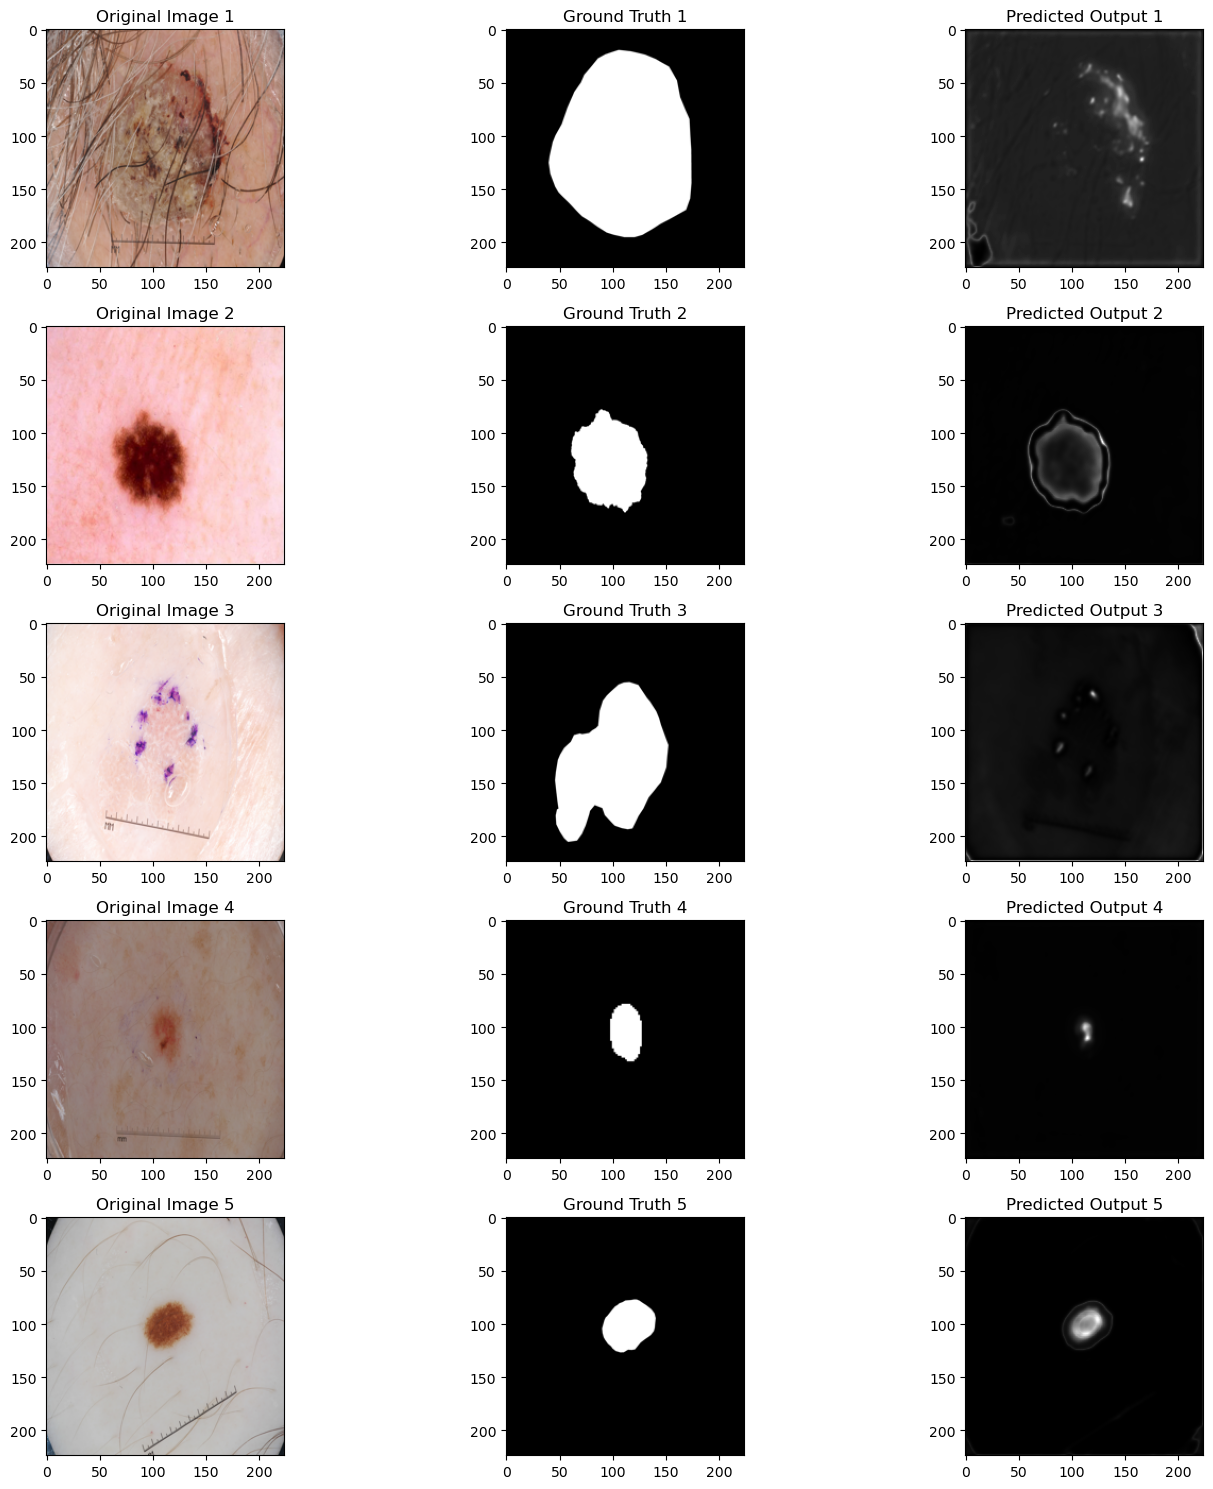

In [35]:
#Prediction for a batch of images
import matplotlib.pyplot as plt

# Assuming x_batch is your batch of images
predictions = model.predict(x_test)

# Visualize the results for the first few images in the batch
num_images_to_visualize = min(len(x_test), 5)

plt.figure(figsize=(15, 3 * num_images_to_visualize))

for i in range(num_images_to_visualize):
    plt.subplot(num_images_to_visualize, 3, 3 * i + 1)
    plt.imshow(x_test[i])
    plt.title(f'Original Image {i + 1}')

    plt.subplot(num_images_to_visualize, 3, 3 * i + 2)
    plt.imshow(y_test[i].reshape(224, 224), plt.cm.binary_r)
    plt.title(f'Ground Truth {i + 1}')

    plt.subplot(num_images_to_visualize, 3, 3 * i + 3)
    plt.imshow(predictions[i].reshape(224, 224), plt.cm.binary_r)
    plt.title(f'Predicted Output {i + 1}')

# Optionally, you can add the ground truth for comparison
# Assuming y_batch is your batch of ground truth masks
if 'y_batch' in locals():
    for i in range(num_images_to_visualize):
        plt.subplot(num_images_to_visualize, 3, 3 * i + 3)
        plt.imshow(y_test[i], plt.cm.binary_r)
        plt.title(f'Ground Truth {i + 1}')

plt.tight_layout()
plt.show()


In [ ]:
# like the previous, but can do for all epochs
#Prediction for a batch of images
import matplotlib.pyplot as plt

# Assuming x_batch is your batch of images
predictions = model.predict(x_test)

# Visualize the results for the first few images in the batch
num_images_to_visualize = min(len(x_test), 5)

plt.figure(figsize=(15, 3 * num_images_to_visualize))

for i in range(num_images_to_visualize):
    plt.subplot(num_images_to_visualize, 3, 3 * i + 1)
    plt.imshow(x_test[i])
    plt.title(f'Original Image {i + 1}')

    plt.subplot(num_images_to_visualize, 3, 3 * i + 2)
    plt.imshow(y_test[i].reshape(224, 224), plt.cm.binary_r)
    plt.title(f'Ground Truth {i + 1}')

    plt.subplot(num_images_to_visualize, 3, 3 * i + 3)
    plt.imshow(predictions[i].reshape(224, 224), plt.cm.binary_r)
    plt.title(f'Predicted Output {i + 1}')

# Optionally, you can add the ground truth for comparison
# Assuming y_batch is your batch of ground truth masks
if 'y_batch' in locals():
    for i in range(num_images_to_visualize):
        plt.subplot(num_images_to_visualize, 3, 3 * i + 3)
        plt.imshow(y_test[i], plt.cm.binary_r)
        plt.title(f'Ground Truth {i + 1}')

plt.tight_layout()
plt.show()


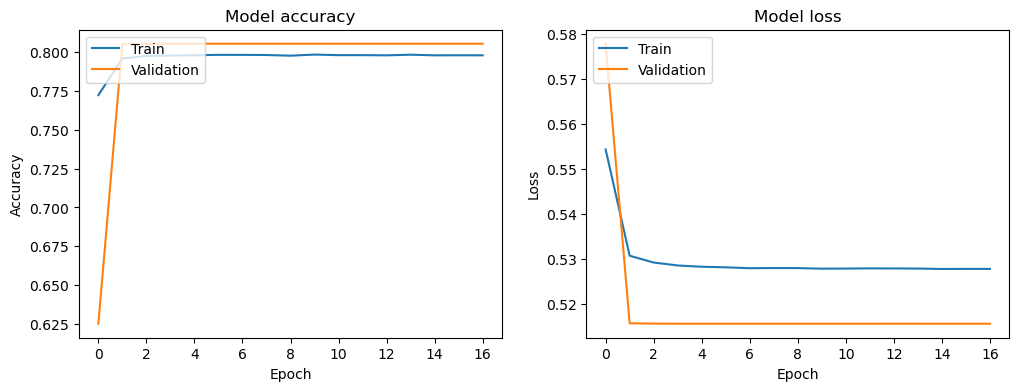

In [36]:
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']


# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# plt.show()

In [29]:
hist.history.keys()

dict_keys(['loss', 'iou', 'dice_coe', 'precision', 'recall', 'accuracy', 'val_loss', 'val_iou', 'val_dice_coe', 'val_precision', 'val_recall', 'val_accuracy'])

In [45]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


In [25]:
hist